# Setup environment

In [2]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning')
    data_folder = Path('/content')

    !pip install pytorch-lightning -U -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import FastDownload for optimized, parallel downloading of files
#from fastdownload import FastDownload

In [4]:
# d = FastDownload(base = data_folder, archive='archive', data='datasets')
# url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'

# # Download the Imagenette dataset using FastDownload and store it in the specified data folder
# data_folder_imagenette2 = d.get(url)

In [5]:
custom_function_folder = base_folder/'Custom_files'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'Models'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'data/imagenette2'
kaggle_api_folder = base_folder/'data/.kaggle'

In [6]:
project_folder

PosixPath('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/data/imagenette2')

In [7]:
# import Libraries
import yaml
import torch
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils_imagenette import  plot_losses_acc

# Function to load the model

In [8]:
# Function to load the model
def load_model(config):
    model = TwoLayerMLPBN(**config)
    return model


# Functions for Transformations

In [9]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [10]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = ImagenetteDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

# Function to load LightningModule

In [11]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [12]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [13]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [14]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [15]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(custom_function_folder/'model_config.yaml')
    data_module_config = load_yaml(custom_function_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(custom_function_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(custom_function_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(custom_function_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

# Function to free memory

In [16]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [16]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
281 M     Trainable params
0         Non-trainable params
281 M     Total params
1,126.252 Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_li

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Val_Loss: 5.61, Val_Metric: 0.16 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 4.93, Train_Metric: 0.00


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.002154434690031884
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6c28413a-c40f-4855-b24c-f96d02904ccb.ckpt


Train_Loss: 2.30, Train_Metric: 0.27


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6c28413a-c40f-4855-b24c-f96d02904ccb.ckpt


0.002154434690031884


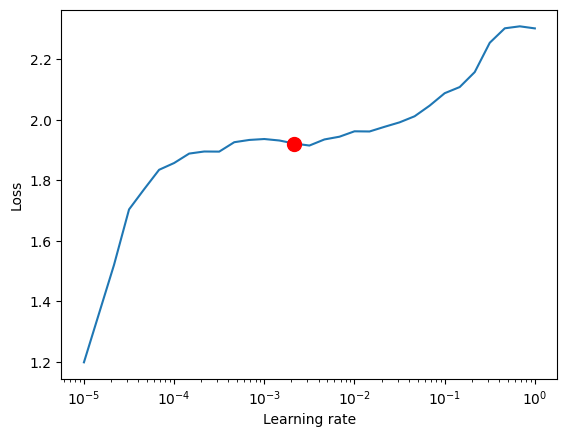

In [17]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs'] = 5
data_module_config['data_module']['batch_size']= 64
model_config['num_classes'] = 10

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Overfit Small Subset

In [18]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size'] = 128
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate'] = 0.0021
trainer_config['max_epochs'] = 3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | TwoLayerMLPBN      | 281 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_me

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Val_Loss: 4.81, Val_Metric: 0.00 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:268: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Val_Loss: 69.76, Val_Metric: 0.05 | Train_Loss: 4.98, Train_Metric: 0.00


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Val_Loss: 5.51, Val_Metric: 0.10 | Train_Loss: 4.12, Train_Metric: 0.32


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Val_Loss: 5.30, Val_Metric: 0.10 | Train_Loss: 3.15, Train_Metric: 0.99


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


# Regularization -I
- Early stopping with a patience of 5, total epochs = 50
- Gradient Clipping
- Weight Deacay of 1
- Reduce Learning rate on plateau
- Use 50% of train/val data

In [17]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size'] = 64
lightning_module_config['others']['learning_rate'] = 0.0021
trainer_config['max_epochs']= 50
trainer_config['gradient_clip_val']= 2
trainer_config['log_every_n_steps']= 20

lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['others']['learning_rate']=0.007
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'epoch', 'frequency': 1}
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass'
cl_config['wandb']['name']='two_layer_mlp_bn_v0'

data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

INFO:lightning_fabric.utilities.seed:Seed set to 42
wandb: Currently logged in as: shremuk. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Models/logs exists and is not empty.
INFO

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Epoch 1: Val_Loss: 4.81, Val_Metric: 0.00 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Val_Loss: 1.91, Val_Metric: 0.33 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved. New best score: 0.330


Train_Loss: 2.10, Train_Metric: 0.28


OSError: ignored

# Regularization -II
- Increase the weight decay to 10

In [ ]:
lightning_module_config

In [ ]:
lightning_module_config['others']['optimizer_params']['weight_decay']=10

In [ ]:
lightning_module_config

In [ ]:
# Regularization -II
free_memory()
seed_everything(42)

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# HW5 PART A - Complete Regularization -III and IV

# Regularization -III
- Use one Cycle Learning Rate instead of Reduce Learning Rate on Plateau

In [ ]:
free_memory()
seed_everything(42)


model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']= 128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20
trainer_config['max_epochs']=10

lightning_module_config['others']['optimizer_params']['weight_decay']=10


# Setting the scheduler class
lightning_module_config['scheduler_cls'] = # CODE HERE

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = # CODE HERE

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = # CODE HERE



model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False) # change here
dm.prepare_data()

trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()

# Regularization-1V
- Use one Step LR instead of One Cycler LR

In [ ]:
free_memory()
seed_everything(42)

model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.007
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20
trainer_config['max_epochs']=10

lightning_module_config['others']['optimizer_params']['weight_decay']=10


# Setting the scheduler class
lightning_module_config['scheduler_cls'] = # CODE HERE

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = # CODE HERE

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = # CODE HERE



model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False) # change here
dm.prepare_data()

trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()